In [1]:
import json
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import SimpleRNN, GRU, LSTM
from keras.layers.core import Dense, Dropout
from keras.layers.wrappers import TimeDistributed
from keras.layers import Convolution1D, MaxPooling1D
from keras.utils import np_utils
import itertools
import ast
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import sys, os
import traceback
from itertools import chain
import numpy as np
import pandas as pd

import progressbar

import tensorflow as tf
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

Using TensorFlow backend.


In [2]:
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def read_data(rootdir):
    data_list = []
    for subdir, dirs, files in os.walk(rootdir):
        for fname in files:
            #print os.path.join(subdir, file)
            filepath = subdir + os.sep + fname
            with open(filepath) as f:
                for line1,line2 in itertools.izip_longest(*[f]*2):
                    try:
                        text = ast.literal_eval(line1)
                        label = ast.literal_eval(line2)
                        
#                         for i in range(len(label)):
#                             if label[i] == 'NA':
#                                 label[i] = 'O'
                        n_labels = set(label)
                        if len(text) > 3 and len(n_labels) > 1:
                            sentence = zip(text, label)
                            sentence.append(('.', 'O'))
                            sentence = [item for item in sentence if item[0].strip() != '']
                            data_list.append(sentence)
                    except:
                        pass
            f.close()
    return data_list

In [4]:
data_list = read_data('../data/input/output_so/')

print data_list[0]

# data_list = data_list[:3000]

# words = list(chain.from_iterable(data_list))
# print words

print len(data_list)

words = list(set(y[0] for x in data_list for y in x))
words.append("ENDPAD")
n_words = len(words)
print n_words

tags = list(set(y[1] for x in data_list for y in x))
n_tags = len(tags)
print n_tags

[('A', 'O'), ('Hybrid', 'O'), ('Photoreceptor', 'O'), ('Expressing', 'O'), ('Both', 'O'), ('Rod', 'O'), ('and', 'O'), ('Cone', 'O'), ('Genes', 'SO:0000704'), ('in', 'O'), ('a', 'O'), ('Mouse', 'O'), ('Model', 'O'), ('of', 'O'), ('Enhanced', 'O'), ('SCone', 'O'), ('Syndrome', 'O'), ('.', 'O')]
7262
15606
156


In [5]:
# from sklearn.preprocessing import LabelEncoder

# le = LabelEncoder()
# le.fit(list(y[1] for x in data_list for y in x))

# labels2idx = dict(zip(le.classes_, le.transform(le.classes_)))

# idx2la = {labels2idx[k]:k for k in labels2idx}

In [6]:
max_len = 75
max_len_char = 10

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1
word2idx["O"] = 0
idx2word = {i: w for w, i in word2idx.items()}
tag2idx = {t: i + 1 for i, t in enumerate(tags)}
tag2idx["O"] = 0
idx2tag = {i: w for w, i in tag2idx.items()}

# print word2idx['Hybrid']
# print tag2idx["O"]

In [7]:
print tag2idx

{'SO:0000994': 1, 'SO:0000993': 2, 'SO:0000188': 3, 'SO:0000159': 87, 'SO:0000855': 4, 'SO:0000854': 5, 'SO:0000857': 6, 'SO:0000856': 7, 'SO:0000851': 8, 'SO:0000853': 9, 'SO:0000667': 10, 'SO:0001077': 11, 'SO:0000859': 12, 'SO:0000858': 13, 'SO:0001452': 14, 'SO:0001453': 15, 'SO:0001450': 16, 'SO:0001451': 17, 'SO:0001454': 18, 'SO:1000035': 19, 'SO:0000051': 20, 'SO:0000345': 21, 'SO:0000346': 22, 'SO:0000110': 23, 'SO:0000340': 24, 'SO:0000112': 25, 'SO:0000296': 26, 'SO:0001183': 27, 'SO:0001185': 28, 'SO:0001059': 29, 'SO:0000860': 30, 'SO:0000865': 31, 'SO:0000902': 32, 'SO:0001442': 33, 'SO:0000906': 34, 'SO:0000673': 35, 'SO:0001444': 36, 'SO:0001441': 37, 'SO:0001114': 38, 'SO:0001445': 39, 'SO:0000771': 40, 'SO:0001447': 41, 'SO:0001446': 42, 'SO:0000068': 43, 'SO:0001448': 44, 'SO:0000104': 45, 'SO:0000984': 46, 'SO:0000577': 47, 'SO:0000879': 48, 'SO:0000646': 50, 'SO:0001025': 153, 'SO:0000077': 53, 'SO:0000360': 54, 'SO:0000407': 55, 'SO:0000988': 56, 'SO:0000985': 57,

In [8]:
from keras.preprocessing.sequence import pad_sequences
X_word = [[word2idx[w[0]] for w in s] for s in data_list]

In [9]:
X_word = pad_sequences(maxlen=max_len, sequences=X_word, value=word2idx["O"], padding='post', truncating='post')

In [10]:
chars = set([w_i for w in words for w_i in w])
n_chars = len(chars)
print(n_chars)

103


In [11]:
char2idx = {c: i + 2 for i, c in enumerate(chars)}
char2idx["UNK"] = 1
char2idx["O"] = 0

In [12]:
X_char = []
for sentence in data_list:
    sent_seq = []
    for i in range(max_len):
        word_seq = []
        for j in range(max_len_char):
            try:
                word_seq.append(char2idx.get(sentence[i][0][j]))
            except:
                word_seq.append(char2idx.get("PAD"))
        sent_seq.append(word_seq)
    X_char.append(np.array(sent_seq))


In [13]:
y = [[tag2idx[w[1]] for w in s] for s in data_list]

In [14]:
y = pad_sequences(maxlen=max_len, sequences=y,value=tag2idx["O"], padding='post', truncating='post')

In [15]:
from sklearn.model_selection import train_test_split
X_word_tr, X_word_te, y_tr, y_te = train_test_split(X_word, y, test_size=0.3, random_state=2018)
X_char_tr, X_char_te, _, _ = train_test_split(X_char, y, test_size=0.3, random_state=2018)

In [16]:
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Conv1D
from keras.layers import Bidirectional, concatenate, SpatialDropout1D, GlobalMaxPooling1D

# input and embedding for words
word_in = Input(shape=(max_len,))
emb_word = Embedding(input_dim=n_words + 2, output_dim=len(tag2idx),
                     input_length=max_len, mask_zero=True)(word_in)

# input and embeddings for characters
char_in = Input(shape=(max_len, max_len_char,))
emb_char = TimeDistributed(Embedding(input_dim=n_chars + 2, output_dim=30,
                           input_length=max_len_char, mask_zero=True))(char_in)
# character LSTM to get word encodings by characters
char_enc = TimeDistributed(GRU(units=150, return_sequences=False,
                                recurrent_dropout=0.5))(emb_char)

# main LSTM
x = concatenate([emb_word, char_enc])
x = SpatialDropout1D(0.3)(x)
main_lstm = Bidirectional(GRU(units=100, return_sequences=True,
                               recurrent_dropout=0.6))(x)
out = TimeDistributed(Dense(n_tags + 1, activation="sigmoid"))(main_lstm)

model = Model([word_in, char_in], out)

In [17]:
from keras.optimizers import RMSprop

rmsopt = RMSprop(lr=0.01, rho=0.9, epsilon=None, decay=0.0)
model.compile(optimizer=rmsopt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [18]:
model.summary()



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 75, 10)       0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 75)           0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 75, 10, 30)   3150        input_2[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 75, 156)      2434848     input_1[0][0]                    
__________________________________________________________________________________________________
time_distr

In [19]:
history = model.fit([X_word_tr,
                     np.array(X_char_tr).reshape((len(X_char_tr), max_len, max_len_char))],
                    np.array(y_tr).reshape(len(y_tr), max_len, 1),
                    batch_size=32, epochs=15, validation_data=([X_word_te,
                     np.array(X_char_te).reshape((len(X_char_te), max_len, max_len_char))],
                    np.array(y_te).reshape(len(y_te), max_len, 1)),
                    verbose=1)

Train on 5083 samples, validate on 2179 samples
Epoch 1/15
5083/5083 [==============================] - 53s 10ms/step - loss: 0.3152 - acc: 0.9451 - val_loss: 0.0764 - val_acc: 0.9840
Epoch 2/15
5083/5083 [==============================] - 52s 10ms/step - loss: 0.0574 - acc: 0.9862 - val_loss: 0.0571 - val_acc: 0.9867
Epoch 3/15
5083/5083 [==============================] - 52s 10ms/step - loss: 0.0438 - acc: 0.9885 - val_loss: 0.0542 - val_acc: 0.9858
Epoch 4/15
5083/5083 [==============================] - 52s 10ms/step - loss: 0.0378 - acc: 0.9894 - val_loss: 0.0521 - val_acc: 0.9871
Epoch 5/15
5083/5083 [==============================] - 52s 10ms/step - loss: 0.0336 - acc: 0.9898 - val_loss: 0.0485 - val_acc: 0.9880
Epoch 6/15
5083/5083 [==============================] - 52s 10ms/step - loss: 0.0299 - acc: 0.9910 - val_loss: 0.0490 - val_acc: 0.9879
Epoch 7/15
5083/5083 [==============================] - 52s 10ms/step - loss: 0.0287 - acc: 0.9913 - val_loss: 0.0487 - val_acc: 0.9883


In [20]:
hist = pd.DataFrame(history.history)
hist.to_csv('../data/results/performance/SO_CHAR_GRU_Based.tsv', sep='\t')

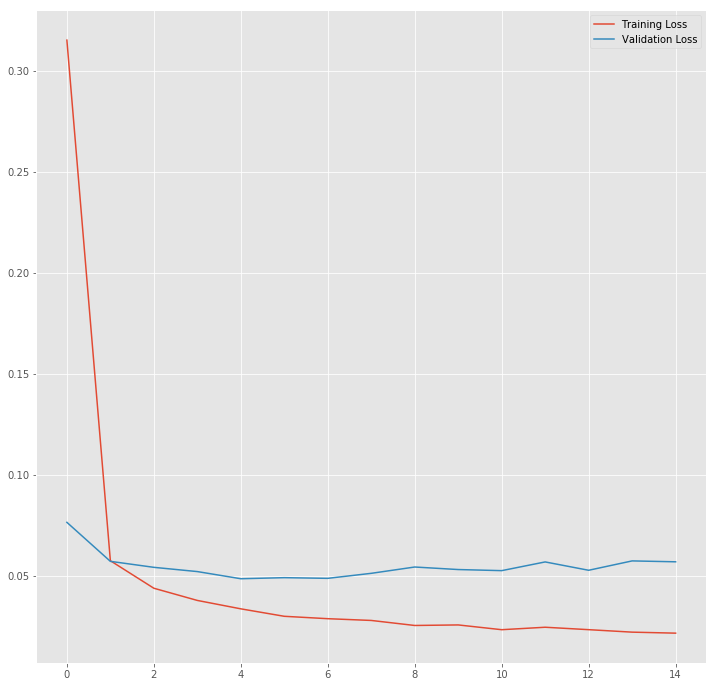

In [21]:
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["loss"], label='Training Loss')
plt.plot(hist["val_loss"], label='Validation Loss')
plt.legend()
plt.show()

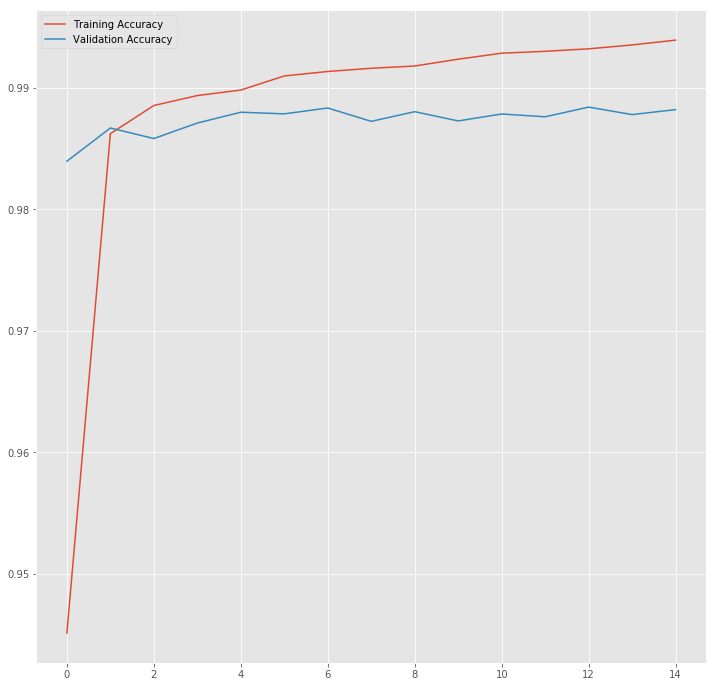

In [22]:
plt.style.use("ggplot")
plt.figure(figsize=(12,12))
plt.plot(hist["acc"], label='Training Accuracy')
plt.plot(hist["val_acc"], label='Validation Accuracy')
plt.legend()
plt.show()

In [23]:
from sklearn.metrics import classification_report

predicted = model.predict([X_word_te,
                        np.array(X_char_te).reshape((len(X_char_te),
                                                     max_len, max_len_char))])
true = []
predicted_val = []
word = []
for i in range(len(predicted)):
    p_tmp = np.argmax(predicted[i], axis=-1)
    t_tmp = y_te[i]
    word.append(X_word_te[i])
    predicted_val.append(p_tmp)
    true.append(t_tmp)

print word[2]
print predicted_val[2]
print true[2]

wd = [list(map(lambda x: idx2word[x], y)) for y in word]    
p = [list(map(lambda x: idx2tag[x], y)) for y in predicted_val]
t = [list(map(lambda x: idx2tag[x], y)) for y in true]


print wd[2]
print p[2]
print t[2]

report = classification_report(list(itertools.chain.from_iterable(t)), 
                                    list(itertools.chain.from_iterable(p)))
print "\n"
print report

[ 6718 10786  8410 14818  8418  5466  7636  2711  2369  5199 12330  1531
 12101 13074  5199  9818 12101  1789  5199 15275 15302   769  4076  8813
  4686  1208  1905  5019  5199 15302  8420 11773   207   597     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0]
[  0   0   0   0   0   0   0   0   0   0   0   0  83   0   0   0  83   0
   0 156  29   0   0   0 147  99   0   0   0  29   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[  0   0   0   0   0   0   0   0   0   0   0   0  83   0   0   0  83   0
   0 156  29   0   0   0 147  99   0   0   0  29   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0 

/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/sdmohant/.virtualenvs/deeplearn/local/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [24]:
i = 300
pred = np.argmax(predicted[i], axis=-1)
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, tr, pred in zip(X_word_te[i], y_te[i], pred):
    if w != 0:
        print("{:15}: {:5} {}".format(words[w], idx2tag[tr], idx2tag[pred]))

# pd = model.predict(np.array([X_te[i]]))
# pd = np.argmax(pd, axis=-1)
# true = np.argmax(y_te[i], -1)
# print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
# print(30 * "=")

# for w, t1, pred in zip(X_te[i], true, pd[0]):
#     if w != 0:
#         print("{:15}: {:5} {}".format(words[w-1], tags[t1], tags[pred]))

Word           ||True ||Pred
target         : SO:0000704 SO:0000704
insights       : O     O
break          : O     O
glucokinase    : O     O
contamination  : O     O
normalize      : O     O
BCAA           : O     O
subunits       : O     O
mouse          : O     O
BMPs           : O     O
layers         : O     O
Occurrence     : O     O


In [25]:
import pandas as pd

df = pd.DataFrame(
{
    'Predicted' : list(itertools.chain.from_iterable(p)),
    'Ground Truth': list(itertools.chain.from_iterable(t)),
    'Word' : list(itertools.chain.from_iterable(wd)),
}
)


In [26]:
df = df[df['Word'] != 'O']

In [27]:
df1 = df[(df['Predicted'] != 'O') & (df['Ground Truth'] != 'O') | 
         (df['Predicted'] == 'O') & (df['Ground Truth'] != 'O') |
         (df['Predicted'] != 'O') & (df['Ground Truth'] == 'O')
        ]
report = classification_report(df1['Ground Truth'], 
                                    df1['Predicted'])
print "\n"
print report



                        precision    recall  f1-score   support

                     O       0.00      0.00      0.00       387
            SO:0000001       0.81      0.92      0.86       500
            SO:0000005       1.00      1.00      1.00         6
            SO:0000006       0.60      0.96      0.74        25
            SO:0000028       0.98      0.91      0.94        54
            SO:0000041       0.76      0.79      0.78        33
            SO:0000045       0.63      0.83      0.72        58
            SO:0000046       0.62      0.82      0.71        34
            SO:0000047       1.00      0.40      0.57         5
            SO:0000048       1.00      1.00      1.00        11
            SO:0000049       0.00      0.00      0.00         4
            SO:0000051       0.97      1.00      0.99        74
            SO:0000068       1.00      0.89      0.94         9
            SO:0000077       1.00      1.00      1.00         3
            SO:0000104       0.00    

In [28]:
df.to_csv('../data/results/SO_CHAR_GRU_Based.tsv', sep='\t')

In [29]:
%run ./accuracy/src/computeSim.py ../data/results/SO_CHAR_GRU_Based.tsv ../data/validation_data/SO_AllSubsumers.tsv

Mean semantic similarity:  0.864
